# Data:

In [46]:
dates = ['09-10-2020', '09-09-2020', '07-08-2020', '09-07-2020', '09-06-2020']
tenors = ['3M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '15Y', '20Y', '30Y']
data = [
    [-0.545, -0.529, -0.523, -0.604, -0.471, -0.436, -0.329, -0.237, -0.118, -0.05 ,  0.013,  0.155,  0.505,  0.525,  0.854],
    [-0.504, -0.499, -0.499, -0.561, -0.386, -0.327, -0.179, -0.097, 0.076,  0.161,  0.222,  0.359,  0.718,  0.748,  1.069],
    [-0.502, -0.491, -0.476, -0.462, -0.328, -0.319, -0.209, -0.142, 0.02 ,  0.108,  0.167,  0.293,  0.639,  0.682,  1.011],
    [-0.462, -0.459, -0.447, -0.485, -0.35 , -0.31 , -0.114, -0.053, 0.139,  0.241,  0.307,  0.412,  0.777,  0.828,  1.161],
    [-0.455, -0.446, -0.421, -0.352, -0.235, -0.196,  0.058,  0.138, 0.23 ,  0.418,  0.485,  0.59 ,  0.851,  1.049,  1.427]
]

a) Build  a  pandas  DataFrame  with  the  data  using  the  dates  as  columns  and  year 
fractions of the tenors as index

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
import re

#Get the adjusted index (turn months into year fractions)
adjusted_index = []

#For each maturity string in the index
for mat in tenors:

    # split the number and the time marking
    result = [i for i in re.split(r'([A-Za-z]+)', mat) if i]

    # if the time marking is an 'M' (symbolizing month)
    if result[1]=='M':
        # devide the month by 12 to get the year fraction and append it to the adjusted index
        adjusted_index.append(int(result[0])/12)
    else: # if it is a 'Y' (year)
        # simply append it to the adjusted index
        adjusted_index.append(int(result[0]))


#DataFrame where the dates are not in chronological order
df_unorganized = pd.DataFrame(index = adjusted_index, columns = dates, data = np.array(data).transpose())/100

#DataFrame where the dates are in chronological order
df=df_unorganized[list(reversed(dates))]

print(df)

       09-06-2020  09-07-2020  07-08-2020  09-09-2020  09-10-2020
0.25     -0.00455    -0.00462    -0.00502    -0.00504    -0.00545
0.50     -0.00446    -0.00459    -0.00491    -0.00499    -0.00529
1.00     -0.00421    -0.00447    -0.00476    -0.00499    -0.00523
2.00     -0.00352    -0.00485    -0.00462    -0.00561    -0.00604
3.00     -0.00235    -0.00350    -0.00328    -0.00386    -0.00471
4.00     -0.00196    -0.00310    -0.00319    -0.00327    -0.00436
5.00      0.00058    -0.00114    -0.00209    -0.00179    -0.00329
6.00      0.00138    -0.00053    -0.00142    -0.00097    -0.00237
7.00      0.00230     0.00139     0.00020     0.00076    -0.00118
8.00      0.00418     0.00241     0.00108     0.00161    -0.00050
9.00      0.00485     0.00307     0.00167     0.00222     0.00013
10.00     0.00590     0.00412     0.00293     0.00359     0.00155
15.00     0.00851     0.00777     0.00639     0.00718     0.00505
20.00     0.01049     0.00828     0.00682     0.00748     0.00525
30.00     

b) Plot the yield curve for each date

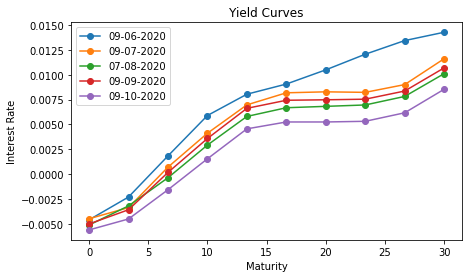

In [49]:
from scipy.interpolate import make_interp_spline

#Establish figure size
plt.figure(figsize=(7, 4))

#For each column/date in the data frame
for (row, col) in enumerate(df):
    # make the lines smoother
    spline = make_interp_spline(adjusted_index, df[col].to_numpy())
    X_ = np.linspace(0, 30, 10)
    Y_ = spline(X_)
    # plot the yield curves
    plt.plot(X_, Y_, lw=1.5, marker='o')

#Establish figure characteristics and plot it
legends = df.columns.values
plt.legend(legends, loc ="upper left")    
plt.axis('auto')
plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.title('Yield Curves')
plt.show()


c) Estimate the NSS parameters for each date

In [50]:
from scipy.optimize import minimize

#Calculates the NSS estimated interest rate for a certain set of variables and a certain maturity
def nss(p, term):
    beta0, beta1, beta2, beta3, tau1, tau2 = p
    return ( beta0
            +beta1*(1-np.exp(-term/tau1))/(term/tau1)
            +beta2*((1-np.exp(-term/tau1))/(term/tau1)-np.exp(-term/tau1))
            +beta3*((1-np.exp(-term/tau2))/(term/tau2)-np.exp(-term/tau2)))

#Gets the minimum square difference between the points calculated by an NSS curve and the market data provided
def minsq_error(p, x, y): return ((nss(p, x) - y)**2).sum()

#Get the adjusted maturities
x = np.array(adjusted_index)

#Initial estimates for the NSS
#or p0=np.random.rand(6)
p0 = np.array([0.85, 0.45, 0.67, 0.047, 0.49, 0.43])

#Dataframe that will hold the resulting NSS parameters for each date
nss_params = pd.DataFrame(columns=['beta0', 'beta1', 'beta2', 'beta3', 'tau1', 'tau2'])

#Iterate through the original dataframe (the one provided in the exercise)
for (row, col) in enumerate(df):

    # get the rates for the day we are currently calculating the NSS params for
    y = np.array(df[col].values)

    # get the NSS values that minimize the min square between a created curve and the rate values that were given
    p = minimize(minsq_error, p0, args=(x, y))['x']
    
    # store the optimized NSS values in a new dataframe with the date as an index
    nss_params.loc[col]=p

nss_params

,beta0,beta1,beta2,beta3,tau1,tau2
09-06-2020,0.018235,-0.022781,-0.018606,-0.005012,3.010990,3.133116
09-07-2020,0.014696,-0.019096,0.133830,-0.166111,1.716477,1.843566
07-08-2020,0.013538,-0.018689,0.146911,-0.174909,1.956998,2.095312
09-09-2020,0.013982,-0.018558,0.103558,-0.133308,2.062722,2.150384
09-10-2020,0.011933,-0.017018,0.126731,-0.155323,2.102826,2.220676


d) Plot the NSS Yield Curve for each date

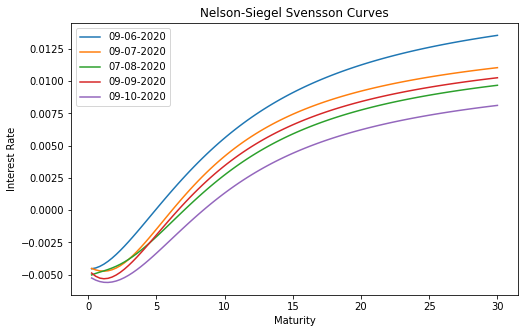

In [51]:
#Establish figure size
plt.figure(figsize=(8,5))

#We iterate each row in the nss params dataframe
for ind, row in nss_params.iterrows():

    # get all the NSSparams calculated for this date (index)
    p = row.values

    # define the spacing of the maturity points we want (x.min=lowest adjusted mat, x.max()=highest adj mat)
    xx = np.linspace(x.min(), x.max(), 100)

    # get the NSS formula values corresponding to the maturity points we defined previously
    nss_yc = np.array([nss(p, t) for t in xx])

    # plot the curve
    plt.plot(xx, nss_yc, label=ind)

#Name the plot
plt.title('Nelson-Siegel Svensson Curves')
#Place the label window in the best spot in the figure
plt.legend(loc='best')
plt.xlabel("Maturity")
plt.ylabel("Interest Rate")
plt.show()


e) Plot the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor)

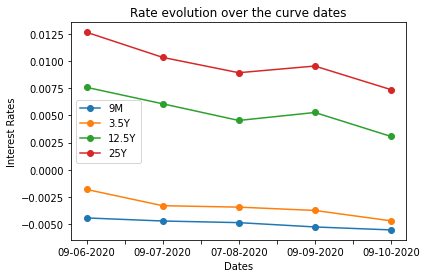

In [52]:
#Create a dataframe to hold the values
new_mat_df = pd.DataFrame(columns=['9M', '3.5Y', '12.5Y', '25Y'])

#The maturities we want to feed the NSS curves in order to get the corresponding estimated interest rate
new_mat=[0.75, 3.5, 12.5, 25]

#We iterate each row in the nss params dataframe
for ind, row in nss_params.iterrows():

    # get all the NSSparams calculated for this date (index)
    p = row.values

    # get the NSS formula values corresponding to the maturity points we feed it (new_mat)
    new_mat_df.loc[ind]= np.array([nss(p, t) for t in new_mat])

#Plot the curves
ax = new_mat_df.plot(use_index=True, title='Rate evolution over the curve dates', marker='o')
ax.set_xlabel("Dates")
ax.set_ylabel("Interest Rates")
plt.show()

f) Plot the market data points vs the NSS fit for each date using 5 subplots sharing 
the y axis (One market date in each subplot) 

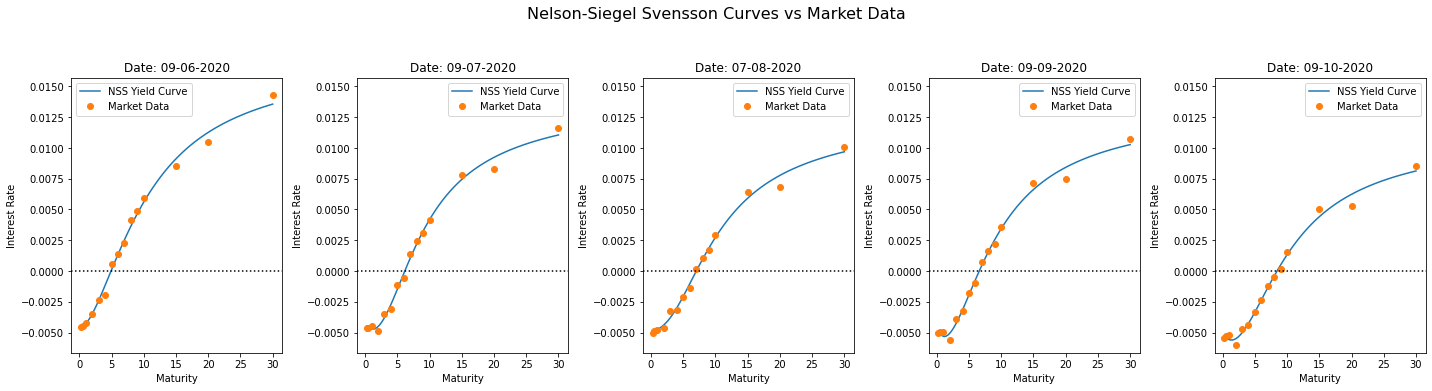

In [53]:
#Get the max and min values in the market data and add a doubt interval of 10% to them.
#This is used to establish the the upper and lower of all the y-axis for all subplots, 
# in order for the 0 value to be centered between all of them
min_y = df.min().min()+df.min().min()*0.1
max_y = df.max().max()+df.max().max()*0.1

#Get the maturities array again (not needed, just to refresh the memory)
x = np.array(adjusted_index)

#Establish how many subplots we want. In this case we say 1 lines with 5 subplots
fig, ax = plt.subplots(1, 5, figsize=(20,5.5))
ax = ax.flatten()

#We iterate each row in the nss params dataframe
for line_number, (ind, row) in enumerate(nss_params.iterrows()):

    # get all the NSSparams calculated for this date (index)
    p = row.values

    # define the spacing of the maturity points we want
    xx = np.linspace(x.min(), x.max(), 100)

    # get the NSS formula values corresponding to the maturity points we defined previously
    nss_yc = np.array([nss(p, t) for t in xx])

    # plot the curve
    ax[line_number].plot(xx, nss_yc, label='NSS Yield Curve')

    # get the market data interest rates (that were given to us) for the current date in analysis
    y = np.array(df[ind].values)
    
    # plot the market data
    ax[line_number].plot(x, y, 'o', label='Market Data')

    # plot a line to show the zero in the y-axis
    ax[line_number].axhline(y = 0, color = 'k', linestyle = ':')

    # set the y-axis limits
    ax[line_number].set_ylim(min_y, max_y)
    
    # add a legend, title and x&y labels to each subplot
    ax[line_number].legend()
    ax[line_number].set_title('Date: '+ind)
    ax[line_number].set_xlabel("Maturity")
    ax[line_number].set_ylabel("Interest Rate")


#Name the plot
fig.suptitle('Nelson-Siegel Svensson Curves vs Market Data', fontsize=16)

#Remove overlap between the subplots
fig.tight_layout()

#Adjust title height
fig.subplots_adjust(top=0.80)



g) Make a function that will give the daycount fraction between two dates for either 
convention Act/360 or Act/365 using date strings as inputs. 
Example: dayCount('15-06-2020', '15-12-2021', 'Act/360')

In [54]:
from datetime import datetime

def dayCount(first_date, second_date, convention):

    # turn the dates to datetime format to allow subtraction
    first_date = datetime.strptime(first_date, "%d-%m-%Y")
    second_date = datetime.strptime(second_date, "%d-%m-%Y")
    
    #Apply the formulas according to the string provided
    if convention == 'Act/360':
        return (second_date - first_date).days/360
    elif convention == 'Act/365':
        return (second_date - first_date).days/365
    else:
        return "Convention " + convention + " is not recognized!!"

In [55]:
print(dayCount('15-06-2020', '15-12-2021', 'Act/360'))
print(dayCount('15-06-2020', '15-12-2021', 'Act/365'))
print(dayCount('15-06-2020', '15-12-2021', 'Act/245'))

1.5222222222222221
1.5013698630136987
Convention Act/245 is not recognized!!


h) Make a function that not only returns the present value of a future investment 
for a given rate but also prints a custom string. Use it to determine the present 
value  of  a  payment  of  EUR  2,430.04  in  5  years  at  the  rate  of  5%  (Annual 
compounded rate) and print whatever string you want.  
Example: pv(amount, rate, maturity, text)

In [56]:
def present_val(amount, rate, maturity, text):

    # since the rate us given as percentage, we need to divide it by 100
    rate= rate/100

    # print the custom phrase
    print('Your custom phrase is:', text)

    # return the present value of the payment
    return amount/(1+rate)**maturity

In [57]:
present_val(2430.04, 5, 5, "I hope all of this is correct")

Your custom phrase is: I hope all of this is correct


1903.9999255650137